https://www.kdnuggets.com/2023/08/leveraging-xgboost-timeseries-forecasting.html#:~:text=Often%20the%20use%20cases%20are,XGBoost%20can%20also%20be%20extended

https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [64]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.graphics as sg


import matplotlib.pylab as plt

import seaborn as sns
sns.set_theme()

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as st


from sklearn import metrics 

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
df = pd.read_csv('../data/ts.csv', index_col=0, parse_dates=True)
df.shape, df.columns

((43, 11),
 Index(['rynek', 'inflacja_r', 'inflacja_q', 'stopa_procentowa',
        'liczba_kredytow', 'tempo_wzrostu', 'ufnosc', 'duze_zakupy',
        'bezrobocie', 'spr_detaliczna', 'pkb'],
       dtype='object'))

In [66]:
df["quarter"] = pd.PeriodIndex(df.index, freq='Q').map(lambda r: int(str(r)[-1]))

drugiej połowie 2023 wynika z uruchomienia rządowego programu kredytów z preferencyjnym oprocentowaniem Bezpieczny Kredyt 2% (program był aktywny w okresie 01-07-2023 do 31-12-2023)

In [67]:
df["rpk"] = 0
df.loc[dt.datetime(year=2023, month=7, day=1): dt.datetime(year=2024, month=1, day=1), "rpk"] =1
df.rpk

2014-03-31    0
2014-06-30    0
2014-09-30    0
2014-12-31    0
2015-03-31    0
2015-06-30    0
2015-09-30    0
2015-12-31    0
2016-03-31    0
2016-06-30    0
2016-09-30    0
2016-12-31    0
2017-03-31    0
2017-06-30    0
2017-09-30    0
2017-12-31    0
2018-03-31    0
2018-06-30    0
2018-09-30    0
2018-12-31    0
2019-03-31    0
2019-06-30    0
2019-09-30    0
2019-12-31    0
2020-03-31    0
2020-06-30    0
2020-09-30    0
2020-12-31    0
2021-03-31    0
2021-06-30    0
2021-09-30    0
2021-12-31    0
2022-03-31    0
2022-06-30    0
2022-09-30    0
2022-12-31    0
2023-03-31    0
2023-06-30    0
2023-09-30    1
2023-12-31    1
2024-03-31    0
2024-06-30    0
2024-09-30    0
Name: rpk, dtype: int64

In [68]:
df.head()

,rynek,inflacja_r,inflacja_q,stopa_procentowa,liczba_kredytow,tempo_wzrostu,ufnosc,duze_zakupy,bezrobocie,spr_detaliczna,pkb,quarter,rpk
2014-03-31,6193.211456,100.6,100.2,0.0446,41942.0,104.2,-20.5,-16.3,13.5,105.5,103.8,1,0
2014-06-30,6227.984614,100.3,100.0,0.0447,45499.0,104.1,-16.8,-15.0,12.0,105.1,103.9,2,0
2014-09-30,6357.260998,99.7,99.5,0.0443,43653.0,103.3,-16.9,-12.7,11.5,102.6,104.2,3,0
2014-12-31,6438.874574,99.3,99.6,0.0388,42993.0,103.3,-13.8,-10.7,11.4,103.7,103.9,4,0
2015-03-31,6473.616559,98.5,99.5,0.0348,42169.0,104.0,-14.9,-11.5,11.5,104.4,104.3,1,0


In [89]:
bn = 41
train, test = df.iloc[:bn], df.iloc[bn:]
train.index, test.index, len(train), len(test)

(DatetimeIndex(['2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
                '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
                '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
                '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
                '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
                '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
                '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
                '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
                '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
                '2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
                '2024-03-31'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2024-06-30', '2024-09-30'], dtype='datetime64[ns]', freq=None),
 41,
 2)

In [90]:
X_train = train.drop('rynek', axis=1)
y_train = train['rynek']

X_test = test.drop('rynek', axis=1)
y_test = test['rynek']

In [91]:
reg = xgb.XGBRegressor(n_estimators=100)


In [92]:
reg.fit(X_train, y_train, verbose = False)

/home/volodya/code/ds/pkobp/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
reg

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

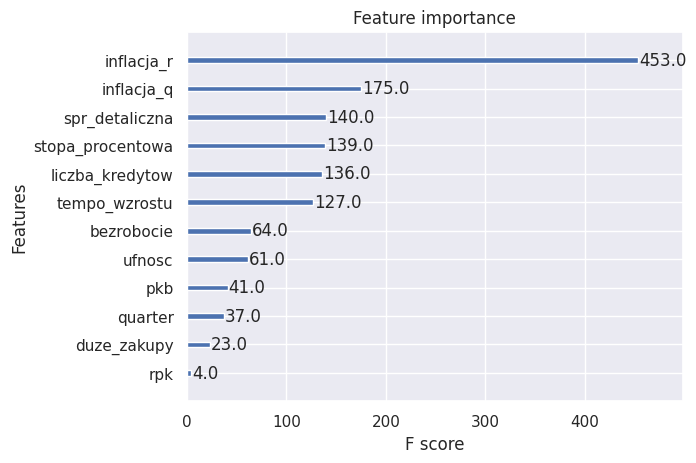

In [94]:
xgb.plot_importance(reg)

In [95]:
test['rynek_Prediction'] = reg.predict(X_test)

/tmp/ipykernel_52991/3183305155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rynek_Prediction'] = reg.predict(X_test)


In [96]:
test

,rynek,inflacja_r,inflacja_q,stopa_procentowa,liczba_kredytow,tempo_wzrostu,ufnosc,duze_zakupy,bezrobocie,spr_detaliczna,pkb,quarter,rpk,rynek_Prediction
2024-06-30,14718.380953,102.5,101.4,0.0819,45434.0,110.9,-12.4,-12.8,4.9,104.8,103.2,2,0,12657.301758
2024-09-30,14988.365863,104.5,101.6,0.0809,47100.0,110.8,-14.6,-13.1,5.0,98.5,102.7,3,0,11717.372070


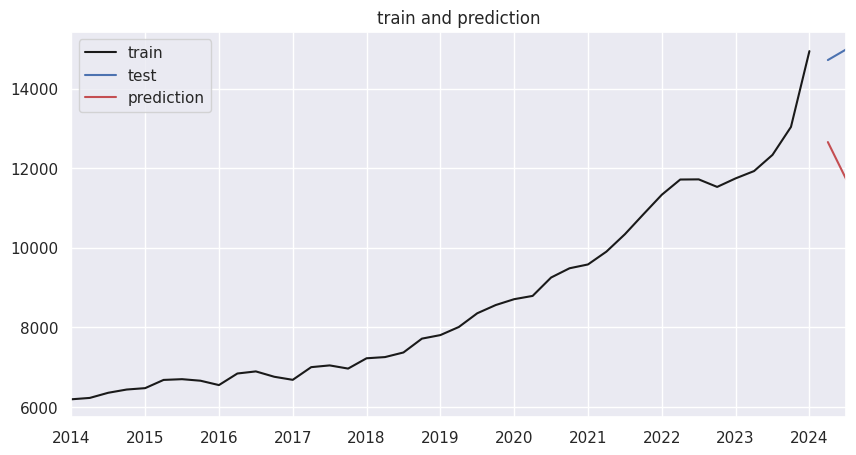

In [97]:
train['rynek'].plot(style='k', figsize=(10,5), label = 'train')
test['rynek'].plot(style='b', figsize=(10,5), label = 'test')
test['rynek_Prediction'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('train and prediction')
plt.legend()

In [98]:
print('RMSE: ', round(metrics.mean_squared_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))
print('MAE: ', round(metrics.mean_absolute_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))
print('MAPE: ', round(metrics.mean_absolute_percentage_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))

RMSE:  7473723.919
MAE:  2666.036
MAPE:  0.179
